# Belief Networks -  Full Notebook

This python 3.9.6 Jupyter Notebook accompanies the Notes for Dr. Bob's Notes Print on July 8, 2024.  

Bob's notes are being transferred to overleaf:  
https://www.overleaf.com/project/66db219c36bf8a9d0d99ab5d

This book was last edited on 
Last edited: Friday, Sep 13, 10:00AM

Table of Contents:
* 0 - Loading the Ground Truth, Experts, and Input Data
    * 0.1 Loading Ground Truth from MNIST
    * 0.2 Creating Experts using TensorFlow
    * 0.3 Loading Prebuilt Experts
    * 0.4 Loading New Images for Examples
* 1 - Probability Assessment
    * 1.1 Basic Assigment
    * 1.2 Density Function Shape
    * 1.3 Weighted Self Assessment - Expert Quality Score (p~)
    * 1.4 Weighted Self Assessment - Expert Self Assessment of Certitude (V*)
    * 1.5 and 1.6 Triangle Base Width and Triangle Height
    * 1.7 Certainty
* 2 - Belief Network Approach
    * 2.1 Rationale
    * 2.2 Basics
    * 2.3 Relative Importance
    * 2.4 Label Probabilities
    * 2.5 Sampling
    * 2.6 An Example
    * 2.7 A Few more Examples
    * 2.8 Multiple Experts at Work (Convolution of uncertainties)
        * 2.8.1 Convolution of Certainties
        * 2.8.2 Convolution of Certainty with Uncertainty
    * 2.9 An Example of Combining Experts
    * 2.10 A Priori Evaluations
        * 2.10.1 Algorithm1
        * 2.10.2 Algorithm Acceleration
        * 2.10.3 Acceleration Results - Label Elimination
        * 2.10.4 Acceleration Results - Photo Elimination
        * 2.10.5 Histogram Construction
        * 2.10.6 An Example
    * 2.11 Recovery of P[Phi] from P[L] and Recovery of P[L] from P[Phi]
        * 2.11.1 Linear Programming
        * 2.11.2 The Problem at Hand
        * 2.11.3 The Simplex Method
        * 2.11.4 Vertex Traversal
        * 2.11.5 Ideal Case (Exact Solution)
        * 2.11.6 Non-Ideal Case: Coordinate Minimization - A detour
        * 2.11.7 Non-ideal Case: Supremum Norm Minimization
        * 2.11.8 Supremum Norm vs Coordinate Minimization
        * 2.11.9 Objective Function Minimization
        * 2.11.10 Non-Ideal Case: Problem Reformulation for Sup Norm
        * 2.11.11 Non-Ideal Case: Problem Reformulation for L2 Norm
        * 2.11.12 Non-Ideal Case: Monte-Carlo Techniques
    * 2.12 A Posteriori Evaluations
        * 2.12.1 Algorithm 2
        * 2.12.2 Alternate Algorithms
        * 2.12.3 An Example Implementation


    

# Part 0 - Loading the Experts, Ground Truth, and Input Data


### 0.1 - Loading the Ground Truth Image Set (MNIST).   

The Ground Truth Set will be   {Phi1, Phi2, Phin N} where N =10000.  
They will be obtained by using the test_images in the mnist data set.  
Note, we do not need their associated labels. We are simply using the image data.  

In [1]:
# Import Relevant Libraries
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models
import csv
from skimage.metrics import structural_similarity as ssim
from tensorflow.keras.models import load_model
from scipy.optimize import minimize


# Importing the MNIST dataset
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = train_images.reshape((60000, 28, 28, 1)).astype('float32') / 255
test_images = test_images.reshape((10000, 28, 28, 1)).astype('float32') / 255
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

/Users/christopherwaight/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


### 0.2 - Creating Expert Models using Training Loop

If you have experts to load, skip this step.  

In Lieu of Human Experts, we will create 11 Models.  
10 will be considered experts and used to create the Belief Network.  
The 11th will be saved for later.

NB. Be sure to update the save location model_path = f"mnist_expert{epoch}.keras"  # Path to save the model

In [2]:
# import numpy as np
# import tensorflow as tf
# from tensorflow.keras import models, layers

# # Random Seed
# np.random.seed(12883)

# # Create the model
# model = models.Sequential([
#     layers.Conv2D(2, (3, 3), activation='relu', input_shape=(28, 28, 1)),
#     layers.BatchNormalization(),
#     layers.Conv2D(2, (3, 3), activation='relu'),
#     layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(2, (3, 3), activation='relu'),
#     layers.Flatten(),
#     layers.Dense(20, activation='relu'),
#     layers.Dropout(0.5),
#     layers.Dense(20, activation='relu'),
#     layers.Dropout(0.5),
#     layers.Dense(10, activation='softmax')
# ])

# model.summary()

# # Compile the model
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# # Training loop to save 10 different models
# for epoch in range(1,11):  # From epoch 1 to 11 gives us 10
#     print(f"Training epoch {epoch}")
#     current_size = int(2048/(2**(epoch-1)))  # Halve the batch size every epoch
#     model.fit(train_images, train_labels, epochs=1, batch_size=current_size, validation_split=0.25) # Train the model for 1 epoch
#     model_path = f"mnist_expert{epoch}.keras"  # Path to save the model
#     model.save(model_path)  # Save the model
#     print(f"Model saved to {model_path}")

#     # Evaluate the model on the test set
#     test_loss, test_acc = model.evaluate(test_images, test_labels)
#     print(f"Test accuracy after epoch {epoch}: {test_acc}")


### 0.3 - Loading Experts

If you have predefined experts, they can be loaded from here.  
Be sure to update the file paths as needed.

In [3]:
# List of model paths
model_paths = [f"mnist_expert{i+1}.keras" for i in range(10)]
scores = []

# Loop to load, evaluate each model and print test accuracy
for i, path in enumerate(model_paths):
    model = load_model(path)  # Load model
    test_loss, test_acc = model.evaluate(test_images, test_labels)  # Evaluate model
    #print(f"Test accuracy of Expert {i+1}: {test_acc}")  # Print test accuracy
    scores.append(test_acc)  # Append test accuracy to scores list

print("The 10 experts have been loaded")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7779 - loss: 0.9191
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7926 - loss: 0.7698
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6521 - loss: 1.7768
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6155 - loss: 1.4973
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8506 - loss: 0.6878
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8963 - loss: 0.5285
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9368 - loss: 0.2546
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7133 - loss: 1.3220
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8402 - loss: 0.5313
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9448 - loss: 0.2935
The 10 experts have been loaded


### 0.4 - Load the New Input Data Psi

Here, we can load a brand new image to use on Algorithm1 or Algorithm2 Examples.
Uncomment for use

In [4]:
# import cv2
# import numpy as np
# import matplotlib.pyplot as plt
# from skimage.metrics import structural_similarity as ssim
# import tensorflow as tf

# # Load the MNIST expert model 11
# model_path = 'mnist_expert11.keras'  # Adjust this path to where your model is stored
# mnist_expert11 =load_model(model_path)

# # Load a new image
# image_path = "new_character2.JPG"
# image = cv2.imread(image_path)
# image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# image_resized = cv2.resize(image_gray, (28, 28))
# image_resized = 1 - (image_resized / 255.0)
# image_resized[image_resized < 0.50] = 0
# image_resized = cv2.medianBlur(np.float32(image_resized), 3)

# # Apply various image processing techniques
# kernel = np.ones((2, 2), np.uint8)
# image_resized = cv2.dilate(image_resized, kernel, iterations=2)
# image_resized = cv2.erode(image_resized, kernel, iterations=1)
# image_resized = cv2.GaussianBlur(image_resized, (3, 3), 0)

# kernel = np.ones((1, 3), np.uint8)
# image_resized = cv2.dilate(image_resized, kernel, iterations=2)
# image_resized = cv2.erode(image_resized, kernel, iterations=1)
# image_resized = cv2.GaussianBlur(image_resized, (3, 3), 0)

# # Predict using the loaded model
# guess = mnist_expert11.predict(image_resized.reshape(1, 28, 28, 1))
# #print('Model 11 predicts:', np.argmax(guess))
# #print('Softmax outputs:', np.round(guess, 3))
# #print()

# # Display the image
# plt.imshow(image_resized, cmap='gray')
# plt.axis('off')
# plt.show()

# Part 1 - Probability Assessment

### 1.1 - 1.2

Let's cover some basic definitions and nomenclature. 
 
[Notes need to be copied from Handwritten Book]  
[No Code Needed]

### 1.3 Weighted Self Assement : p~ component or " Expert Quality Score"

In [5]:
import numpy as np
from tensorflow.keras.models import load_model

# List of model paths
model_paths = [f"mnist_expert{i+1}.keras" for i in range(10)]
scores = []         # Scores is also used in section 2.11.8

# Loop to load, evaluate each model and print test accuracy
for i, path in enumerate(model_paths):
    model = load_model(path)  # Load model
    test_loss, test_acc = model.evaluate(test_images, test_labels)  # Evaluate model
    scores.append(test_acc)  # Append test accuracy to scores list

print("The Quality Scores for each Expert is :", np.round(scores,4))
print("Scores in ascending order:", sorted(np.round(scores,4)))

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7779 - loss: 0.9191
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7926 - loss: 0.7698
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6521 - loss: 1.7768
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6155 - loss: 1.4973
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8506 - loss: 0.6878
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8963 - loss: 0.5285
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9368 - loss: 0.2546
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7133 - loss: 1.3220
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8402 - loss: 0.5313
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9448 - loss: 0.2935
The Quality Scores for each Expert is : [0.8031 0.8143 0.6785 0.6525 0.8701 0.9096 0.9474 0.7389 0.8501 0.9549]
Scores in ascending order: [0.6525, 0.6785, 0.7389, 0.8031, 0.8143, 0.8501, 0.8701, 0.9096, 0.9474, 0.9549]


### 1.4 Weighted Self Assement : V* component or " Self Certainty Score"

In this section, each expert is asked to provide a label "0,1,2,....9" to each image in the Ground Truth Data Set.  
Furthermore, the expert is asked to give their "Self Certainty Score".  

Since our experts are super human, we can use gradations of 0.01 instead of 0.3

Furthermore, instead of simply giving a reading of  
"Given Phi 1, Expert 1 assigns the label : 8, with a self certainty of: 0.11"  
Our experts give their self certainty for each possible label.:

"Given Phi 1, Expert 1 assigns the label : 0, with a self certainty of: 0.03"   
"Given Phi 1, Expert 1 assigns the label : 2, with a self certainty of: 0.05"     
...   
"Given Phi 1, Expert 1 assigns the label : 9, with a self certainty of: 0.15"  



1.4.1 Using all 1000 images

In [6]:
# import numpy as np
# import matplotlib.pyplot as plt
# from tensorflow.keras.models import load_model

# # Load models and get predictions
# num_models = 10  # Specify the number of models
# predictions = []
# predicted_classes = []

# for i in range(1, num_models + 1):
#     model = load_model(f"mnist_expert{i}.keras")  # Load each model
#     pred = model.predict(test_images)  # Predict with the model
#     predictions.append(pred)
#     predicted_classes.append(np.argmax(pred, axis=1))  # Convert softmax to class predictions

# # True classes
# true_classes = np.argmax(test_labels, axis=1)

# # Identify misclassified examples for each model
# misclassified_by_model = [np.where(pred_classes != true_classes)[0] for pred_classes in predicted_classes]

# # Count misclassifications for each image
# misclassification_counts = {}
# for model_misclassified_indices in misclassified_by_model:
#     for index in model_misclassified_indices:
#         misclassification_counts[index] = misclassification_counts.get(index, 0) + 1

# # Sort indices by the number of times they were misclassified, in descending order
# sorted_misclassified_indices = sorted(misclassification_counts, key=misclassification_counts.get, reverse=True)

# # Display 16 random images from misclassified indices in a 4x4 grid
# random_misclassified_indices = np.random.choice(sorted_misclassified_indices, 16, replace=False)
# fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20, 20))

# print()
# print('Each Expert rated 10,000 images')
# print('Below are 16 random images from this Ground Truth Set')
# print('It shows the phi Index')
# print('And the Label each expert assigns to it')


# for ax, index in zip(axes.flatten(), random_misclassified_indices):
#     ax.imshow(test_images[index].reshape(28, 28), cmap='gray')
#     predictions_for_plot = [predicted_classes[i][index] for i in range(num_models)]  # Predictions from all models for this index
#     ax.set_title(f"Phi Index: {index}\nExpert Labels: {predictions_for_plot}")
#     ax.axis('off')

# plt.tight_layout()
# plt.show()

# # Print prediction and softmax output for each randomly selected misclassified index
# for index in random_misclassified_indices:
#     print()
#     print(f"Given the Ground Truth Photo Index: {index}")
#     for i in range(num_models):
#         self_certainty = np.round(np.max(predictions[i][index]),2)
#         print(f"Expert {i+1} assigns the label : {predicted_classes[i][index]}, with a self certainty of:" , self_certainty)


#### Update! - Smaller Ground Truth Set (100 photos vs 10,000) and Sparsity by Thresholding.

You may want to use a smaller Ground Truth. 
Here has 10 photos of each class (digit).    
This is more realistic anyways, if the expertss were to be human. Can't overwork them.  
We are calculating the self certainty p~ for each expert below.  
   
All values below 0.1 are clipped. the remaining values are normalized.

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/stepWARNING:tensorflow:6 out of the last 12 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x31e9630d0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
4/4 ━━━━━━━━━━━

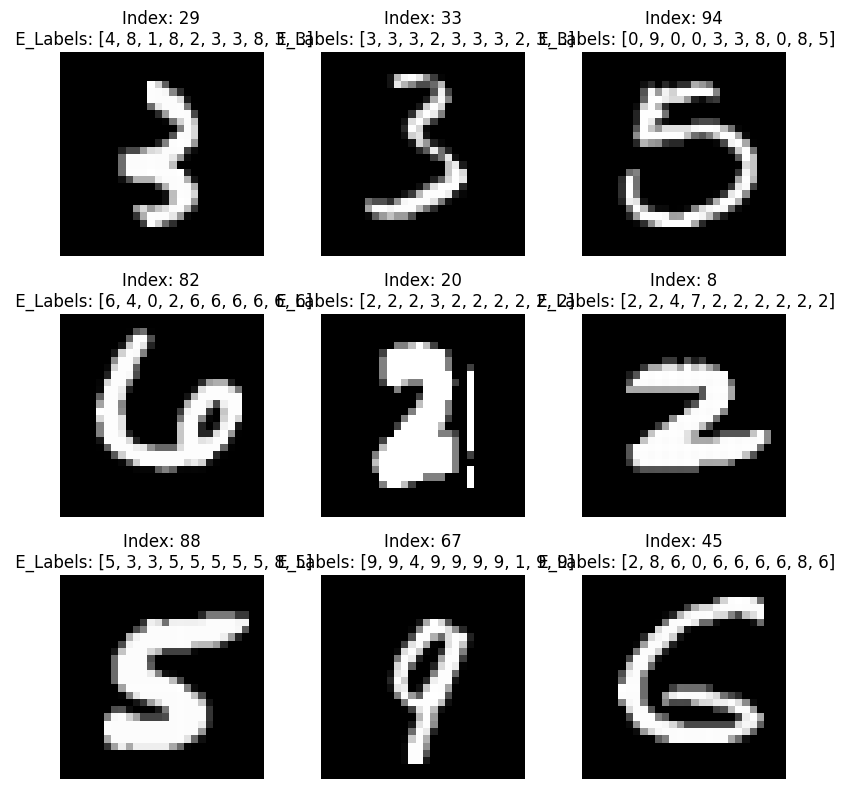


Index: 29
Expert 1 assigns the label: 4, with a self certainty of: 0.16
Expert 2 assigns the label: 8, with a self certainty of: 0.22
Expert 3 assigns the label: 1, with a self certainty of: 0.13
Expert 4 assigns the label: 8, with a self certainty of: 0.13
Expert 5 assigns the label: 2, with a self certainty of: 0.34
Expert 6 assigns the label: 3, with a self certainty of: 0.41
Expert 7 assigns the label: 3, with a self certainty of: 0.59
Expert 8 assigns the label: 8, with a self certainty of: 0.12
Expert 9 assigns the label: 3, with a self certainty of: 0.6
Expert 10 assigns the label: 3, with a self certainty of: 1.0

Index: 33
Expert 1 assigns the label: 3, with a self certainty of: 0.48
Expert 2 assigns the label: 3, with a self certainty of: 0.56
Expert 3 assigns the label: 3, with a self certainty of: 0.16
Expert 4 assigns the label: 2, with a self certainty of: 0.14
Expert 5 assigns the label: 3, with a self certainty of: 0.27
Expert 6 assigns the label: 3, with a self certai

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# True classes from the full test_labels
true_classes_full = np.argmax(test_labels, axis=1)

# Create a balanced subset of 100 images, ensuring each digit 0-9 is represented equally
indices_per_class = 10  # Number of indices per class to achieve 100 images total
selected_indices = []

for digit in range(10):
    digit_indices = np.where(true_classes_full == digit)[0]
    selected_digit_indices = np.random.choice(digit_indices, indices_per_class, replace=False)
    selected_indices.extend(selected_digit_indices)

# Ensure the selected indices are shuffled to mix the digits
np.random.shuffle(selected_indices)

# Slicing the test_images and test_labels to get only the selected subset
subset_test_images = test_images[selected_indices]
subset_test_labels = test_labels[selected_indices]

# Load models and get predictions
num_models = 10  # Specify the number of models
predictions = []
predicted_classes = []

for i in range(1, num_models + 1):
    model = load_model(f"mnist_expert{i}.keras")  # Load each model
    pred = model.predict(subset_test_images)  # Predict with the model on the subset
    predictions.append(pred)
    predicted_classes.append(np.argmax(pred, axis=1))  # Convert softmax to class predictions

# True classes for the subset
true_classes = np.argmax(subset_test_labels, axis=1)

# Identify misclassified examples for each model
misclassified_by_model = [np.where(pred_classes != true_classes)[0] for pred_classes in predicted_classes]

# Count misclassifications for each image in the subset
misclassification_counts = {}
for model_misclassified_indices in misclassified_by_model:
    for index in model_misclassified_indices:
        misclassification_counts[index] = misclassification_counts.get(index, 0) + 1

# Sort indices by the number of times they were misclassified, in descending order
sorted_misclassified_indices = sorted(misclassification_counts, key=misclassification_counts.get, reverse=True)

# Display 9random images from misclassified indices in a 3x3 grid
random_misclassified_indices = np.random.choice(sorted_misclassified_indices, 16, replace=False)
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(8, 8))

for ax, index in zip(axes.flatten(), random_misclassified_indices):
    ax.imshow(subset_test_images[index].reshape(28, 28), cmap='gray')
    predictions_for_plot = [predicted_classes[i][index] for i in range(num_models)]  # Predictions from all models for this index
    ax.set_title(f"Index: {index}\n E_Labels: {predictions_for_plot}")
    ax.axis('off')

plt.tight_layout()
plt.show()

# Print prediction and softmax output for each randomly selected misclassified index
for index in random_misclassified_indices:
    print()
    print(f"Index: {index}")
    for i in range(num_models):
        self_certainty = np.round(np.max(predictions[i][index]),2)
        print(f"Expert {i+1} assigns the label: {predicted_classes[i][index]}, with a self certainty of:" , self_certainty)


### 1.5 - 1.6 Triangle Height and Width for Uncertainty.

Uncomment to use

Sections 1.5 and 1.6 describe how p~ and V* can be used to create Triangular Probability Density functions.

Instead, this notebook will use Normal Functions as Probability Densities instead of Triangular Probability Density functions.

In this implementation, Probability Density Functions are created as follows:

f = (mean, std_dev)  
f = (p*V~, insert here)  
f = clip f between 0 and 1  

This approach creates Probability Density Functions with the following Properties:
* Area under Clipped Normal curve equals to 1
* All values between 0 and 1
* Independence, each expert is independent of others, and each photograph rating is indepdent. In other words, experts don't get smarter / learn as they go and can't peak at other experts to influence their decisions.

The mean (mu) is calculated as mu = p*v~ and the standard deviation  is sqrt (mu * (1-mu) / Num_samples ).  

NB. In the event that p*V~ is very close to 0, or very close 1, it is better to treat this as a certainty than as an uncertainty (see 1.7)


In [8]:
# ### Try this code with different values for Self Certainty !!!!

# self_certainty_test_value = 0.99

# import numpy as np
# import matplotlib.pyplot as plt

# # Parameters
# mu = self_certainty_test_value
# n_samples = 10_000  # Each expert takes n_samples of tests to determine their quality score
# sigma = np.sqrt(mu*(1-mu)*(1/n_samples))


# # Generating samples
# samples = np.random.normal(mu, sigma, n_samples)

# # Clipping samples
# clipped_samples = np.clip(samples, 0, 1)


# # Plotting normalized histogram
# plt.figure(figsize=(6, 6))
# plt.hist(samples, bins=100, color='green', alpha=0.7, density=False)
# plt.title(f"Histogram of {n_samples} Random Samples")
# plt.xlabel('Value')
# plt.ylabel('Probability Density')
# plt.grid(True)
# plt.show()


# # Plotting normalized histogram
# plt.figure(figsize=(6, 6))
# plt.hist(clipped_samples, bins=100, color='green', alpha=0.7, density=True)
# plt.title('Clipped Normal Distribution')
# plt.xlabel('Value')
# plt.ylabel('Probability Density')
# plt.grid(True)
# plt.show()


# # Plotting normalized histogram
# plt.figure(figsize=(6, 6))
# plt.hist(clipped_samples, bins=100, color='green', alpha=0.7, density=True)
# plt.title('Clipped Normal Distribution - Zoom out')
# plt.xlabel('Value')
# plt.xlim(0, 1)  # Setting the x-axis limits to [0, 1]
# plt.ylabel('Probability Density')
# plt.grid(True)
# plt.show()


### 1.7 Certainty

In the case of certainty, we use a dirac-delta function.  
In implementation, what this means is that instead of sampling from a fxn, we use a constant value.

Notice, if the score is .999 and only 1000 tests were taken, then the histogram in 1.6 becomes very distorted from Normal.

[No Code For this Section]

# 2 Belief Network Approach

### 2.1 - 2.2 Rationale and the Basics

[ Definitions and Notes need to be added]  
[No Code Needed]

### 2.3 - 2.4 Relative Importance and Label Probabilities

[ Definitions and Notes need to be added]  
[No Code Needed]

### 2.5 Sampling

Sampling can be done by usign a cummulative distribution fucntion, then uniform sampling between 0 and 1.

However, in this notebook, we are using samlping tools such as np.random.uniform and np.random normal.

[No code needed]

### 2.6 Belief Networks - A Toy Example

Uncomment for use. 
Using Figure 3 from the notebook.

Let the Phi's be .7/.91 , .2/.91 , .01/.91

We will let these have a sigma of 0.01/ sqrt(12)

To get the sigmas from triangle functions, we will let the base span/ sqrt(12)

Photo, Label, Inference, Left End, Centre, Right End, Mu, standard deviation.  
1 L1 f11  0.5  0.75  1.0  0.75, 0.083  
1 L2 f12  0.8  0.90  1.0  0.9,  0.033  
2 L1 f21  0.7  0.80  0.9  0.8   0.033  
2 L2 f23  0.3  0.40  0.5  0.4   0.033  
3 L3 f33  0.9  0.95  1.0  0.9   0.017  

This will be a 3x3 Matrix,  
f11 f12 f13  
f21 f22 f23  
f31 f32 f33  
With all missing entries from above equal to 0

NB. The output has different values than Dr. Bob's work.  

For comparison, I will also use hardcoded Values for my best guess of what E[x] should be.

In [9]:
# iterations = 10_000
# allvalues = []

# for _ in range(iterations):
#     phis = np.array([np.random.normal(0.7 / 0.91, 0.0041), np.random.normal(.2/.91, 0.0041), np.random.normal(.01/.91, 0.0041) ])
#     phis = np.clip(phis,0,1)

#     F1 = np.array([np.random.normal(0.75, .102), np.random.normal(.9,.041), 0 ])
#     F2 = np.array([np.random.normal(0.8, .041), np.random.normal(.4, .041), 0 ])
#     F3 = np.array([0,0, np.random.normal(0.95, 0.02) ])
#     F = np.vstack([F1,F2,F3])
#     F = np.clip(F,0,1)
#     dotprod = F.dot(phis)
#     allvalues.append(dotprod)

# # Plotting normalized histogram
# allvalues = np.array(allvalues)

# print('Mean of 1', np.mean(allvalues[:,0]))
# print('Mean of 2', np.mean(allvalues[:,1]))
# print('Mean of 3', np.mean(allvalues[:,2]))

# print ('Now using only the means (no sampling)')

# A = np.vstack([[0.75,.9,0],[0.8,0.4,0],[0,0,.95]])
# b = np.array([0.7,0.2,0.01])/.91
# exval = A.dot(b)
# print(exval)

# # Plotting normalized histogram
# plt.figure(figsize=(8, 6))

# # Colors for each column
# colors = ['red', 'blue', 'green']
# labels = ['L1', 'L2', 'L3']

# # Plot histograms for each column
# for i in range(allvalues.shape[1]):
#     plt.hist(allvalues[:, i], bins=50, alpha=0.7, density=True, color=colors[i], label=labels[i])

# plt.title(f"Histogram of {iterations} Random Samples")
# plt.xlabel('Value')
# plt.ylabel('Density')
# plt.legend()
# plt.grid(True)

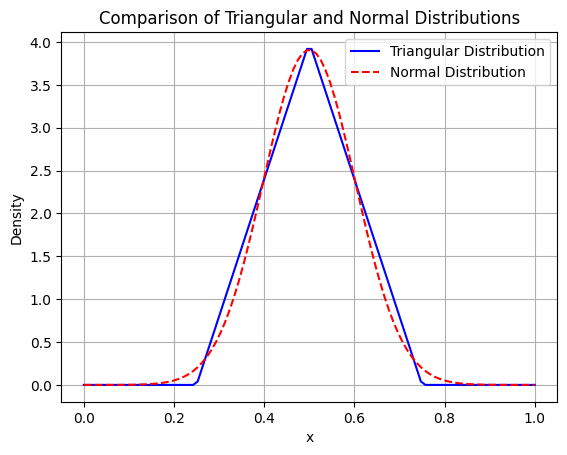

Triangular Distribution Mean: 0.5001063819230704
Triangular Distribution Variance: 0.010424735469904101
Normal Distribution Mean: 0.5000385110059686
Normal Distribution Variance: 0.010425154081203149
Normal Distribution Deviation: 0.10210159386564002


In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, triang

# Parameters for the triangular distribution
a, b, c = 0.25, 0.5, 0.75

# Parameters for the normal distribution
mu = b
sigma = np.sqrt( ( a*a + b*b + c*c - a*b -a*c -b*c) /18  )

# Create an array of x values
x = np.linspace(0,1,100)

# Triangular distribution
height = 2 / (c - a)
width = c-a

triangular = triang.pdf(x, (b-a)/(c-a), loc=a, scale=(c-a))

# Normal distribution
normal = norm.pdf(x, mu, sigma)

# Plot the distributions
plt.plot(x, triangular, label='Triangular Distribution', color='blue')
plt.plot(x, normal, label='Normal Distribution', color='red', linestyle='dashed')
plt.title("Comparison of Triangular and Normal Distributions")
plt.xlabel("x")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()

# Sampling
n_samples = 1_000_000

# Sample from triangular distribution
triangular_samples = np.random.triangular(a, b, c, n_samples)

# Sample from normal distribution
normal_samples = np.random.normal(mu, sigma, n_samples)

# Calculate mean and variance for both samples
triangular_mean = np.mean(triangular_samples)
triangular_variance = np.var(triangular_samples)

normal_mean = np.mean(normal_samples)
normal_variance = np.var(normal_samples)
normal_standarddec = np.sqrt(triangular_variance)

# Print the results
print(f"Triangular Distribution Mean: {triangular_mean}")
print(f"Triangular Distribution Variance: {triangular_variance}")
print(f"Normal Distribution Mean: {normal_mean}")
print(f"Normal Distribution Variance: {normal_variance}")
print(f"Normal Distribution Deviation: {normal_standarddec}")


### 2.7 Another Example

[For Varun: Try to replicate one of these with the numbers above. Determine the std dev using the code above too]


### 2.8 Combining Experts

This code shows the convolution of triangles

In [11]:
# import numpy as np
# import matplotlib.pyplot as plt

# # Define the discretization step
# dx = 0.01

# # Define the ranges for the functions
# x = np.arange(5, 11, dx)

# # Define the first triangle function, centered at 8.0, height=1, width=2
# def triangle(x, center, width, height):
#     return np.maximum(height - np.abs(x - center) / (width / 2), 0)


# # Calculate the triangle functions
# y1 = triangle(x, 8, 2, 2)
# y2 = triangle(x,9,1.2,1.4)
# y3 = triangle(x,7.5,0.8,2)
# # Perform the convolution
# y_convolved = np.convolve(y1, y2, mode='same') * dx
# y_convolved_again = np.convolve(y_convolved, y3, mode='same') * dx


# # Adjust the x-axis for the convolution result to match its length
# x_convolved = np.linspace(x.min(), x.max(), len(y_convolved_again))

# # Plotting
# plt.figure(figsize=(12, 6))

# plt.subplot(2, 1, 1)
# plt.plot(x, y1, label='Triangle 1')
# plt.plot(x, y2, label='Triangle 2')
# plt.plot(x, y3, label='Triangle 3')
# plt.title('Original Triangle Functions')
# plt.legend()

# plt.subplot(2, 1, 2)
# plt.plot(x_convolved, y_convolved_again, color='red', label='Convolved Function')
# plt.title('Convolved Function')
# plt.legend()

# plt.tight_layout()
# plt.show()


However, using Normals, we are able to Convolve in the following way:

Mean = mu1 + mu2 / count(means)

var = (var1 + var2 )/(count(vars)**2)
 

prediceted mean  0.6
0.5999546807390844

predicted variance 0.002011111111111111
0.0020094121257026513


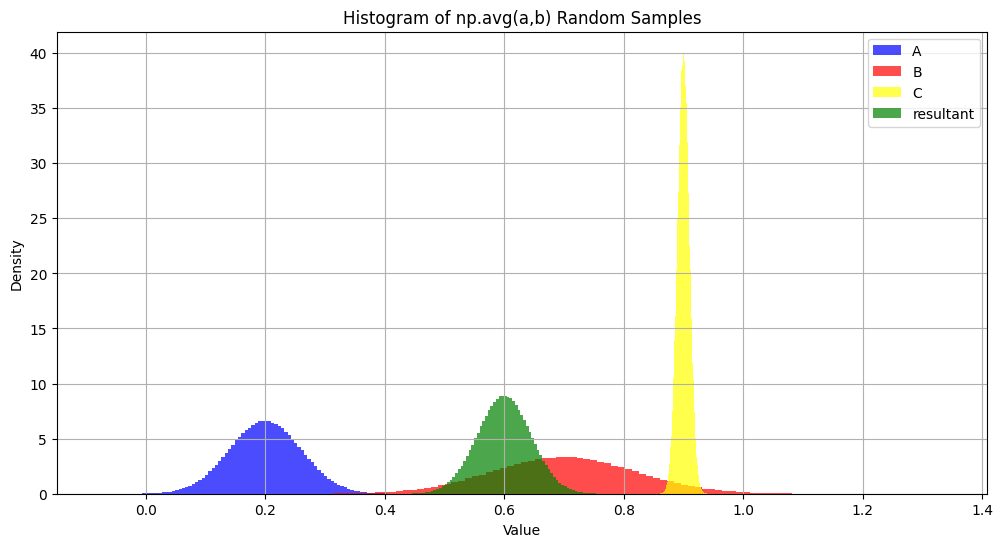

In [12]:
sums = []
a_s = []
bs = []
cs = []
mu1 = .2
var1 = .06

mu2 = .7
var2 = 0.12

mu3 = .9
var3 = 0.01

for _ in range(1_000_000):
    a = np.random.normal(mu1,var1)
    b =  np.random.normal(mu2,var2)
    c =  np.random.normal(mu3,var3)
    #a=np.clip(a,0,1)
    #b=np.clip(b,0,1)
    #c=np.clip(c,0,1)
    a_s.append(a)
    bs.append(b)
    cs.append(c)
    ab_avg = (a+b+c)/3
    sums.append(ab_avg)

# Plotting
plt.figure(figsize=(12, 6))

total_mean = np.mean([mu1,mu2,mu3])
print("prediceted mean ", total_mean)
print(np.mean(sums))
print()
totalvar = (var1**2 + var2**2 + var3**2 ) /9  #+ np.var([mu1,mu2])
print("predicted variance", totalvar )
print(np.var(sums))


plt.hist(a_s, bins=100, alpha=0.7, density=True, color = 'blue', label= 'A')
plt.hist(bs, bins=100, alpha=0.7, density=True, color = 'red', label= 'B')
plt.hist(cs, bins=100, alpha=0.7, density=True, color = 'yellow', label= 'C')
plt.hist(sums, bins=100, alpha=0.7, density=True, color = 'green', label= 'resultant')

plt.title(f"Histogram of np.avg(a,b) Random Samples")
plt.xlabel('Value')
plt.legend()
plt.ylabel('Density')
plt.grid(True)


## 2.9 Belief Networks - Combining Experts Example

Using the Convolution Techniques in 2.8, All "Single Expert Belief Systems" are convolved into a single "Ensemble of Experts Belief System"

In [13]:
# Initialize Expert Quality (1.3) of each model
n = 10_000 # Number of samples
accuracies = np.array(scores)  # This can be found in section 1.3
standard_deviations = np.sqrt(accuracies * (1 - accuracies) / n) 


# Calculating the outputs from several expert models
softmax_outputs = []
for path in model_paths:
    model = load_model(path)
    predictions = model.predict(subset_test_images)
    #print('Predictions', np.round(predictions,3), 'sum', np.sum(predictions))

    predictions[predictions < 0.15] = 0 
    predictions = predictions / (np.sum(predictions, axis=1, keepdims=True) + 10e-7) # 
    #print('Predictions', np.round(predictions,3), 'sum', np.sum(predictions))
    #print()
    softmax_outputs.append(predictions)
#print(np.round(softmax_outputs,2))

# Initialize a 3D array to store the results # Shape: (2 metrics, 10 classes, number of images)
results = np.zeros((2, 10, len(subset_test_images)))  

# For each Image
for index in range(len(subset_test_images)):  # Assuming test_images is defined
    for class_idx in range(10):  # Assuming 10 classes
        total_confidence = []
        total_devs = []

        
        for i, softmax_output in enumerate(softmax_outputs):
            confidence_score = softmax_output[index, class_idx]  # Confidence score for this class from the i-th model
            scaled_confidence = confidence_score * accuracies[i]  # Scaled confidence score
            
            total_confidence.append(scaled_confidence)
            total_devs.append(standard_deviations[i])  # I am not sure I am doing this right
        
        # Calculate averages for this class for this image
        avg_confidence = np.mean(total_confidence)
        total_variance = np.sum([dev**2 for dev in total_devs])/100 # Hard coded value is 10^2 factor.
        
        
        # Store the averages in the results array
        results[0, class_idx, index] = avg_confidence
        results[1, class_idx, index] = total_variance**0.5


# Example: Print the results for the first image across all classes for each metric
#print(f"Average Confidence Scores for Image 0: {results[0, :, 0]}")
#print(f"Average standard deviation for Image 0: {results[1, :, 0]}")
print(f"True class of index 0: {true_classes[0]}, argmax: {np.argmax(results[0, :, 0])}")

print(" All convolutions complete. Belief Network successfully compiled")

display_matrix = (np.round(results[0,:,:],2))
display_matrix.T


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
True class of index 0: 5, argmax: 5
 All convolutions complete. Belief Network successfully compiled


array([[0.  , 0.  , 0.  , 0.14, 0.  , 0.47, 0.  , 0.  , 0.14, 0.  ],
       [0.82, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.02, 0.  , 0.  , 0.  , 0.08, 0.03, 0.  , 0.26, 0.02, 0.35],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.8 , 0.  , 0.02],
       [0.  , 0.  , 0.  , 0.03, 0.  , 0.  , 0.  , 0.73, 0.02, 0.04],
       [0.  , 0.  , 0.05, 0.59, 0.  , 0.09, 0.  , 0.  , 0.02, 0.  ],
       [0.8 , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.02, 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.11, 0.  , 0.  , 0.11, 0.  , 0.54],
       [0.  , 0.  , 0.61, 0.06, 0.  , 0.  , 0.02, 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.02, 0.  , 0.74, 0.  , 0.  , 0.  ],
       [0.  , 0.82, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.82, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.4 , 0.  , 0.03, 0.  , 0.16, 0.  , 0.17, 0.  , 0.  , 0.  ],
       [0.  , 0.06, 0.  , 0.  , 0.  , 0.  , 0.  , 0.42, 0.  , 0.27],
       [0.  , 0.  , 0.08, 0.53, 0.

### 2.10.1 - 2.10.4 Algorithm1 and acceleration techniques

This Describes Algorithm 1.



It then describes some acceleration techniques in 2.10-2.10.4.
I am not implementing these.
[no code needed]

### 2.10.5 Histogram

This section describes how to collect a Histogram of results, similiar to 2.6
It proposes we can use this histogram as a probability function which is the certitude that a label corresponds to the given image.

This would be a very memory intensive approach. An alternative approach is to fit a normal distribution to these histograms and use those instead. Below show 

In [14]:
# iterations = 10_000
# allvalues = []

# for _ in range(iterations):
#     phis = np.array([np.random.normal(0.7 / 0.91, 0.0041), np.random.normal(.2/.91, 0.0041), np.random.normal(.01/.91, 0.0041) ])
#     phis = np.clip(phis,0,1)

#     F1 = np.array([np.random.normal(0.75, .102), np.random.normal(.9,.041), 0 ])
#     F2 = np.array([np.random.normal(0.8, .041), np.random.normal(.4, .041), 0 ])
#     F3 = np.array([0,0, np.random.normal(0.95, 0.02) ])
#     F = np.vstack([F1,F2,F3])
#     F = np.clip(F,0,1)
#     dotprod = F.dot(phis)
#     allvalues.append(dotprod)

# # Plotting normalized histogram
# allvalues = np.array(allvalues)

# print('Mean of 1', np.mean(allvalues[:,0]))
# print('Mean of 2', np.mean(allvalues[:,1]))
# print('Mean of 3', np.mean(allvalues[:,2]))
# print()
# print('Variance of 1', np.var(allvalues[:,0]))
# print('Variance of 2', np.var(allvalues[:,1]))
# print('Variance of 3', np.var(allvalues[:,2]))


# print ('Now using only the means (no sampling)')

# A = np.vstack([[0.75,.9,0],[0.8,0.4,0],[0,0,.95]])
# b = np.array([0.7,0.2,0.01])/.91
# exval = A.dot(b)
# print(exval)

# # Plotting normalized histogram
# plt.figure(figsize=(8, 6))

# # Colors for each column
# colors = ['red', 'blue', 'green']
# labels = ['L1', 'L2', 'L3']

# # Plot histograms for each column
# for i in range(allvalues.shape[1]):
#     plt.hist(allvalues[:, i], bins=50, alpha=0.7, density=True, color=colors[i], label=labels[i])


# # Create an array of x values
# x = np.linspace(0,1,100)

# # Normal distributions
# y1 = norm.pdf(x, np.mean(allvalues[:,0]), np.std(allvalues[:,0]))
# y2 = norm.pdf(x, np.mean(allvalues[:,1]), np.std(allvalues[:,1]))
# y3 = norm.pdf(x, np.mean(allvalues[:,2]), np.std(allvalues[:,2]))

# plt.plot(x, y1, label='Normal Fit to 1')
# plt.plot(x, y2, label='Normal Fit to 2')
# plt.plot(x, y3, label='Normal Fit to 3')



# plt.title(f"Histogram of {iterations} Random Samples")
# plt.xlabel('Value')
# plt.ylabel('Density')
# plt.legend()
# plt.grid(True)

### 2.10.6 A Priori Example


L=F*Phi

Given:
* F - The belief network distributions
* Phi - How much it looks like each image

Solve:
* L - Which labels, and with what certainty

##### If we Knew Phi Somehow

https://en.wikipedia.org/wiki/Structural_similarity_index_measure#Algorithm


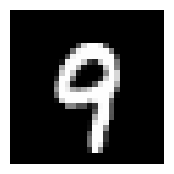

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step

This is all the SSIM scores
[0.0109 0.0069 0.0105 0.0119 0.0112 0.0093 0.0103 0.0158 0.0096 0.009
 0.0102 0.0082 0.0093 0.0108 0.0108 0.0092 0.0074 0.0102 0.0091 0.0085
 0.0089 0.0136 0.0104 0.0087 0.0093 0.0102 0.0093 0.0089 0.0088 0.0125
 0.0083 0.0099 0.01   0.0093 0.0089 0.0092 0.0082 0.0155 0.0088 0.0093
 0.011  0.0164 0.0111 0.012  0.01   0.0078 0.0124 0.0123 0.0101 0.0105
 0.0084 0.0102 0.0095 0.0105 0.0105 0.0127 0.0093 0.0086 0.0097 0.009
 0.0094 0.0094 0.0105 0.0096 0.0112 0.0084 0.0083 0.0121 0.009  0.012
 0.0091 0.0126 0.0096 0.0086 0.0103 0.0083 0.0122 0.0086 0.0091 0.0094
 0.008  0.009  0.0074 0.0102 0.0101 0.0098 0.0101 0.0125 0.0106 0.0112
 0.0116 0.0084 0.0118 0.0085 0.0074 0.0101 0.0089 0.0089 0.0087 0.0103]
Highest phi index: 41, with phi value: 0.0164
Lowest of all phis 0.0069309830798303124
Sum of all phi values 1.0


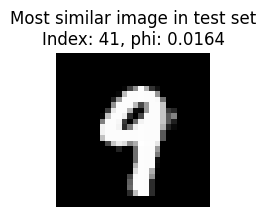

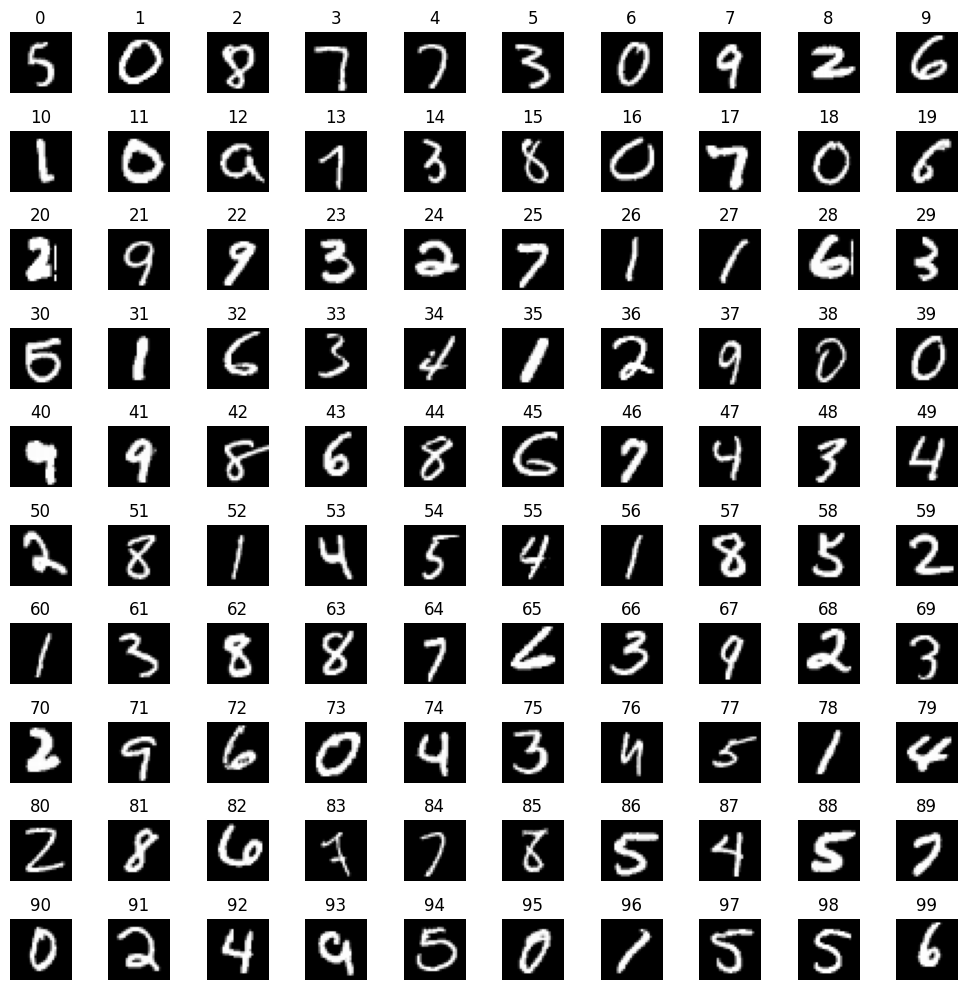

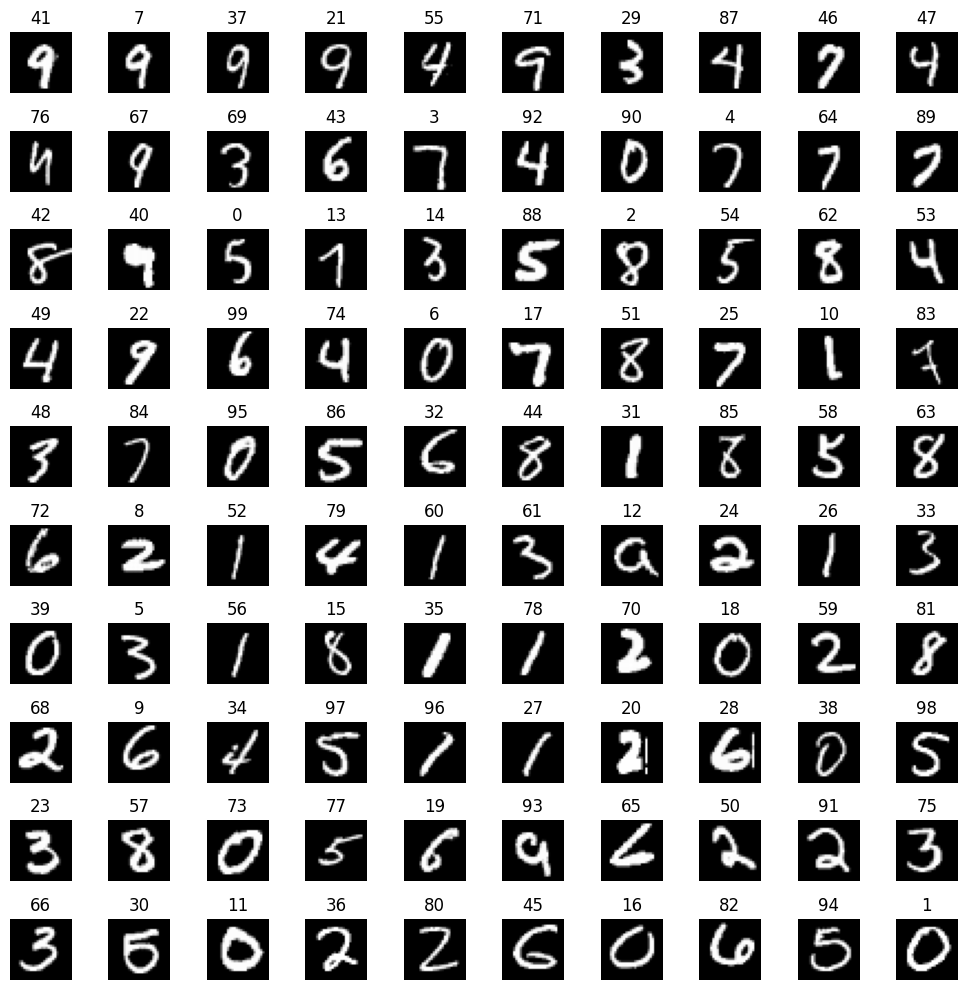

In [15]:
# 1. Import Relevant Libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from skimage.metrics import structural_similarity as compare_ssim

# 2. Load a new image to do forward pass
new_photo_index = np.max(selected_digit_indices)+2 # +12 is good example, +x is good counterexample
image_resized = test_images[new_photo_index]
image_resized = cv2.resize(image_resized, (28, 28))

# Display the image
plt.figure(figsize=(2, 2))
plt.imshow(image_resized, cmap='gray')
plt.axis('off')
plt.show()

# 3. Load the MNIST Expert (model 11)
model_path = 'mnist_expert11.keras'  # Adjust this path to where your model is stored
mnist_expert11 =load_model(model_path)
guess = mnist_expert11.predict(image_resized.reshape(1, 28, 28, 1))
print()



#Get SSIM to each image in Belief Network
ssim_scores = []


for test_image in subset_test_images:
    # Resize the test image to 28x28
    test_image = cv2.resize(test_image, (28, 28))
    ssim2 = compare_ssim(image_resized, test_image, data_range=1)#data_range=test_image.max() - test_image.min())
    ssim_scores.append(ssim2)

# Use Softmax to convert from [-1,1] range to [0,1]
ssim_scores = np.exp(ssim_scores) / np.sum(np.exp(ssim_scores))
print('This is all the SSIM scores')
print(np.round(ssim_scores,4))

max_ssim_index = np.argmax(ssim_scores)
max_ssim_value = ssim_scores[max_ssim_index]
print(f"Highest phi index: {max_ssim_index}, with phi value: {np.round(max_ssim_value,5)}")
print("Lowest of all phis", ssim_scores[np.argmin(ssim_scores)])
print("Sum of all phi values", np.round(np.sum(ssim_scores),6))

# Display the most similar image
plt.figure(figsize=(2, 2))
plt.imshow(subset_test_images[max_ssim_index], cmap='gray')
plt.title(f"Most similar image in test set\nIndex: {max_ssim_index}, phi: {max_ssim_value:.4f}")
plt.axis('off')
plt.show()

# Display a 10x10 grid of all test images
fig, axes = plt.subplots(10, 10, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    ax.imshow(subset_test_images[i], cmap='gray')
    ax.set_title(str(i))  # Set title as the index
    ax.axis('off')
plt.tight_layout()
plt.show()

# Display a 10x10 grid of all test images, sorted by SSIM score
sorted_indices = np.argsort(ssim_scores)[::-1]  # Sort in descending order
fig, axes = plt.subplots(10, 10, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    image_index = sorted_indices[i]  # Get the index from the sorted list
    ax.imshow(subset_test_images[image_index], cmap='gray')
    ax.set_title(str(sorted_indices[i]))  # Set title as the index
    ax.axis('off')
plt.tight_layout()
plt.show()

### Compute Weighted SUM of SSIM

In [16]:
# Compute weighted sum for each label
weighted_sums = np.zeros(10)  # Assuming 10 labels (0-9)

for i, ssim_score in enumerate(ssim_scores):
    label = np.argmax(subset_test_labels[i])       # Find the index of the '1'
    weighted_sums[label] += ssim_score 

# Print the weighted sums for each label
for label, weighted_sum in enumerate(weighted_sums):
    print(f"Label {label}: Weighted sum = {weighted_sum:.4f}")

print("Max class", np.argmax(weighted_sums))

sorted_indices = np.argsort(weighted_sums)[::-1]  
second_highest_index = sorted_indices[1]
second_highest_value = weighted_sums[second_highest_index]
print("Second highest class:", second_highest_index)


Label 0: Weighted sum = 0.0902
Label 1: Weighted sum = 0.0936
Label 2: Weighted sum = 0.0877
Label 3: Weighted sum = 0.0987
Label 4: Weighted sum = 0.1111
Label 5: Weighted sum = 0.0936
Label 6: Weighted sum = 0.0919
Label 7: Weighted sum = 0.1094
Label 8: Weighted sum = 0.0986
Label 9: Weighted sum = 0.1252
Max class 9
Second highest class: 4


In [17]:
# Initialize Constants 
initial_phi = ssim_scores.copy()

num_classes = 10  # Number of classes, 10
num_images = len(subset_test_images)  # 100 in this Belief Network

# Generate random samples directly based on 'results'
mean_confidences = results[0, :, :]  # Shape: (num_classes, num_images, 1)
std_deviations = results[1, :, :]  # Shape: (num_classes, num_images, 1)

M = np.random.normal(mean_confidences, std_deviations)
M[M<0]=0
M[M>1]=1

# Compute L using einsum for efficient computation
L2 = M@initial_phi


for idx in range(10):
    print(f'Class {idx}: ', np.round(L2[idx],4))

print("Max class", np.argmax(L2))


Class 0:  0.0805
Class 1:  0.0801
Class 2:  0.0721
Class 3:  0.0642
Class 4:  0.0749
Class 5:  0.0645
Class 6:  0.0663
Class 7:  0.0995
Class 8:  0.0716
Class 9:  0.0959
Max class 7


### Belief Network tries to match SSIM's

In [18]:
# Initialize Constants 
initial_phi = ssim_scores.copy()

print(np.max(initial_phi))

num_classes = 10  # Number of classes, 10
num_images = len(subset_test_images)  # 100 in this Belief Network
new_dim = 10000  # The new dimension size for einsum


# Generate random samples directly based on 'results'
mean_confidences = results[0, :, :, np.newaxis]  # Shape: (num_classes, num_images, 1)
std_deviations = results[1, :, :, np.newaxis]  # Shape: (num_classes, num_images, 1)


# Use broadcasting to generate the new dimensions
phi_expanded = np.tile(initial_phi, (new_dim, 1)).T 
M_expanded = np.random.normal(mean_confidences, std_deviations, (num_classes, num_images, new_dim))
M = M_expanded
M[M<0]=0
M[M>1]=1
M_expanded = M

# Initialize Constants 
initial_phi = ssim_scores.copy()

num_classes = 10  # Number of classes, 10
num_images = len(subset_test_images)  # 100 in this Belief Network


# Generate random samples directly based on 'results'
mean_confidences = results[0, :, :]  # Shape: (num_classes, num_images, 1)
std_deviations = results[1, :, :]  # Shape: (num_classes, num_images, 1)


# Compute L using einsum for efficient computation
#L2 = M@initial_phi


for idx in range(10):
    print(f'Class {idx}: ', np.round(L2[idx],4))

print("Max class", np.argmax(L2))


# Compute L using einsum for efficient computation
L2 = np.einsum('ijk,jk->ik', M_expanded, phi_expanded)
#print(L2)

print()
L2_avg = np.mean(L2, axis=1)
L2_std = np.std(L2, axis=1)

print("Average Label Values")

for idx in range(10):
    print(f'Class {idx}: ', np.round(L2_avg[idx],4))

print("Max class", np.argmax(L2_avg))


0.016403758673766644
Class 0:  0.0805
Class 1:  0.0801
Class 2:  0.0721
Class 3:  0.0642
Class 4:  0.0749
Class 5:  0.0645
Class 6:  0.0663
Class 7:  0.0995
Class 8:  0.0716
Class 9:  0.0959
Max class 7

Average Label Values
Class 0:  0.0805
Class 1:  0.0801
Class 2:  0.0722
Class 3:  0.0642
Class 4:  0.0749
Class 5:  0.0646
Class 6:  0.0665
Class 7:  0.0995
Class 8:  0.0714
Class 9:  0.0959
Max class 7


### BN shows how certainties

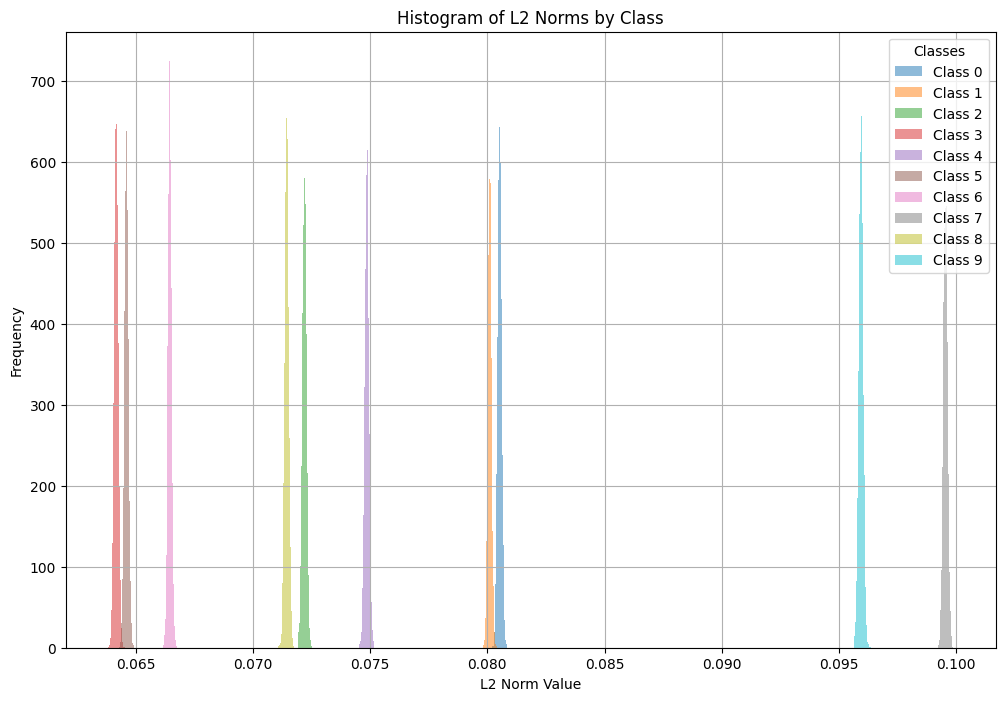

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming L2 is of shape (num_classes, num_images)
num_classes = L2.shape[0]

plt.figure(figsize=(12, 8))

# Plot a histogram for each class
for class_idx in range(num_classes):
    # Extract the L2 norms for the current class
    L2_class = L2[class_idx, :]
    
    # Plot histogram for this class
    plt.hist(L2_class, bins=50, alpha=0.5, label=f'Class {class_idx}')

# Add labels and title
plt.title('Histogram of L2 Norms by Class')
plt.xlabel('L2 Norm Value')
plt.ylabel('Frequency')
plt.legend(title='Classes')
plt.grid(True)
plt.show()


### 2.11 - A Posteriori Example

* 2.11 Recovery of P[Phi] from P[L] and Recovery of P[L] from P[Phi]
    * 2.11.1 Linear Programming
    * 2.11.2 The Problem at Hand
    * 2.11.3 The Simplex Method
    * 2.11.4 Vertex Traversal
    * 2.11.5 Ideal Case (Exact Solution)
    * 2.11.6 Non-Ideal Case: Coordinate Minimization - A detour
    * 2.11.7 Non-ideal Case: Supremum Norm Minimization
    * 2.11.8 Supremum Norm vs Coordinate Minimization
    * 2.11.9 Objective Function Minimization
    * 2.11.10 Non-Ideal Case: Problem Reformulation for Sup Norm
    * 2.11.11 Non-Ideal Case: Problem Reformulation for L2 Norm
    * 2.11.12 Non-Ideal Case: Combining Reformulations
    * 2.11.12 Non-Ideal Case: Monte-Carlo Techniques
* 2.12 A Posteriori Evaluations
    * 2.12.1 Algorithm 2
    * 2.12.2 Alternate Algorithms
    * 2.12.3 An Example Implementation


### 2.11.1, 2.11.2 Linear Programming and  The Problem at Hand

#### Linear Programming

This section gives a quick overview of Linear Programming and Optimization. 


#### The Problem at Hand
In the a priori example, we know F, and Phi, and we compute L.

In this problem, we know L, and F, and want to find Phi with a few constraints.

This can be written as:  

Solve for Phi such that 

L=F*Phi  
phi <= 0  
sum(phi) <=1  

Quick Reminder:  
* F - The belief network distributions
* L - Which labels, and with what certainty
* Phi - How much it looks like each image


### 2.11.3, 2.11.4 -  Simplex Method and Vertex Walk

This section introduces the Simplex Method, and the Vertex walk algorithm by Avis.

The Simplex Method is a well known Linear Programming Algorithm for solving "The problem at hand". The details are not covered here, but are available in standard libraries.

The work from Avis has been expanded, and it has been shown that the algorithm to find all vertices of a polytope can run in polynomial time O(n^3)

The problem is that the numver of vertices scales like O(2^n / n^0.5) 

[ Proof Needed - but can be done by showing how the number of vertices follows the binomial distribution.]

### 2.11.6 - 2.11.9 Supremum Norm Vs Coordinate Minimization


* 2.11.6 Non-Ideal Case: Coordinate Minimization - A detour
* 2.11.7 Non-ideal Case: Supremum Norm Minimization
* 2.11.8 Supremum Norm vs Coordinate Minimization
* 2.11.9 Objective Function Minimization

This section talks about minimizing the change of any one constraint, and minimizing overall changed as well.
It is highly theoretical. Please see notes (no code included for this part)

### 2.11.10 Non-Ideal Case: Problem Reformulation for Sup Norm

As it is, the problem is to solve for the **x** which 

**Minimizes the objective function**  

$$c = \| \mathbf{b} - \mathbf{A}\mathbf{x} \|_{\infty}$$


**Subject to**  

\[
\begin{aligned}
    \mathbf{A}\mathbf{x} &\leq \mathbf{b}, \\
    0 &\leq \mathbf{x}, \\
    \sum_{i} x_i &\leq 1.
\end{aligned}
\]

---

**This can be rewritten as:**  


\begin{aligned}
\text{Solve for the x which minimizes } c = t
\end{aligned}


**Subject to:**  
\[
\begin{aligned}
    \mathbf{A}\mathbf{x} &\leq \mathbf{b}, \\
    0 &\leq \mathbf{x}, \\
    \sum_{i} x_i &\leq 1, \\
    \mathbf{b} - \mathbf{A}\mathbf{x} &\leq t.
\end{aligned}
\]

---

**Putting this in standard form:**  


\begin{aligned}
\text{Solve for the x which minimizes } c = t
\end{aligned}



\begin{aligned}
    \mathbf{A}\mathbf{x} &\leq \mathbf{b}, \\
    0 &\leq \mathbf{x}, \\
    \sum_{i} x_i &\leq 1, \\
    -\mathbf{A}\mathbf{x} - t &\leq -\mathbf{b}, \\
    
\end{aligned}


---

These constraints can be represented in matrix form:

\[
\begin{aligned}
\begin{bmatrix}
\mathbf{A} & 0 \\
-\mathbf{A} & -1
\end{bmatrix}
\begin{bmatrix}
\mathbf{x} \\
t
\end{bmatrix}
&\leq
\begin{bmatrix}
\mathbf{b} \\
-\mathbf{b}
\end{bmatrix}
\end{aligned}
\]


\[
\begin{aligned}
\begin{bmatrix}
\mathbf{A} & 0 \\
-\mathbf{A} & -1 \\
1 & 1
\end{bmatrix}
\begin{bmatrix}
\mathbf{x} \\
t
\end{bmatrix}
&\leq
\begin{bmatrix}
\mathbf{b} \\
-\mathbf{b} \\
1
\end{bmatrix}
\end{aligned}
\]



In this linear form, the problem can be solved using a linear programming (LP) solver.


## Attempt 1 - Using Scipy

In [20]:
import numpy as np
from scipy.optimize import linprog

def linearizewithscipy(A,b):

    x_len = A.shape[1]

    # Objective function: Minimize t
    c = np.zeros(x_len + 1)  # n_vars for x and 1 for t
    c[-1] = 1  # Coefficient of t in the objective function

    # Creating Augmented A and Augmented b matrix
    A_ub = np.hstack([A, -np.zeros((A.shape[0], 1))])
    A_ub = np.vstack( [A_ub, np.hstack ([-A, -np.ones((A.shape[0], 1))] )])
    b_ub = np.hstack([b, -b])


    # Additional constraints: sum(x) <= 1
    A_eq = np.zeros((1, x_len + 1))
    A_eq[0, :x_len] = 1
    b_eq = [1]

    # Bounds for x and t
    bounds = [(0, 1)] * x_len + [(0, None)]  # x in [0, 1] and t in [0, inf]

    # Solving the linear programming problem
    res = linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, bounds=bounds, method='highs')

    # Extracting the solution
    x = res.x[:-1]
    t = res.x[-1] # Sup norm

    # Testing Results
    b_found = A.dot(x)
    bdifference = b - b_found
    score = bdifference
    norm2 = np.linalg.norm(bdifference, 2)
    print("Optimal value of objective function:", t)
    print("Optimal solution x:", x)
    print()
    print('b desired', b)
    print('b found  ', np.round(b_found,3))
    print()
    print('difference', np.round(score,3))

    print('L1 norm is:', t)
    print("L2 norm is: ", norm2)

    return t, x, b_found, bdifference 


# Initializing the A vector
array = [
    [0.9206, 0, 0, 0, 0, 0, 0.9206, 0, 0, 0, 0.6406, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0.9206, 0, 0, 0, 0, 0, 0.9206, 0, 0, 0, 0.6406, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.07943, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0.9206, 0, 0, 0, 0, 0, 0.9206, 0, 0, 0, 0.6406, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.07943, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0.9206, 0, 0, 0, 0, 0, 0.9206, 0, 0, 0, 0.6406, 0, 0, 0, 0.6406, 0, 0, 0, 0, 0, 0.07943, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0.9206, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.6406, 0, 0, 0, 0.6406, 0, 0, 0, 0, 0, 0.07943, 0, 0, 0, 0, 0.07943],
    [0, 0, 0, 0, 0, 0.9206, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.6406, 0, 0, 0, 0.6406, 0.07943, 0, 0, 0, 0, 0.07943, 0, 0, 0.07943, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.6406, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.07943, 0.07943, 0, 0]
]

A = np.array(array)

# Initializing the B Vector
b = [0.4, 0.1, 0.2, 0.05, 0.05, 0, 0.2]
b = np.array(b)

# Solving for x
t, x, b_found, bdifference = linearizewithscipy(A,b)


Optimal value of objective function: 0.025915132408575056
Optimal solution x: [0.40634898 0.08047455 0.18909936 0.02616214 0.02616214 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.27175284 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.        ]

b desired [0.4  0.1  0.2  0.05 0.05 0.   0.2 ]
b found   [0.374 0.074 0.174 0.024 0.024 0.    0.174]

difference [0.026 0.026 0.026 0.026 0.026 0.    0.026]
L1 norm is: 0.025915132408575056
L2 norm is:  0.06347885101767252


### 2.11.11 Non-Ideal Case: Problem Reformulation for L2 Norm


This problem can now be solved using a quadratic programming solver.


In [21]:
import numpy as np
from scipy.optimize import linprog, minimize

# Initializing the A vector
array = [
    [0.9206, 0, 0, 0, 0, 0, 0.9206, 0, 0, 0, 0.6406, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0.9206, 0, 0, 0, 0, 0, 0.9206, 0, 0, 0, 0.6406, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.07943, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0.9206, 0, 0, 0, 0, 0, 0.9206, 0, 0, 0, 0.6406, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.07943, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0.9206, 0, 0, 0, 0, 0, 0.9206, 0, 0, 0, 0.6406, 0, 0, 0, 0.6406, 0, 0, 0, 0, 0, 0.07943, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0.9206, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.6406, 0, 0, 0, 0.6406, 0, 0, 0, 0, 0, 0.07943, 0, 0, 0, 0, 0.07943],
    [0, 0, 0, 0, 0, 0.9206, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.6406, 0, 0, 0, 0.6406, 0.07943, 0, 0, 0, 0, 0.07943, 0, 0, 0.07943, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.6406, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.07943, 0.07943, 0, 0]
]

A = np.array(array)

# Initializing the B Vector
b = [0.4, 0.1, 0.2, 0.05, 0.05, 0, 0.2]
b = np.array(b)

# Define the objective function (L2 norm)
def objective(x):
    return np.linalg.norm(np.dot(A, x) - b, 2)**2

# Define the equality constraint: sum(x) == 1
def constraint_eq(x):
    return np.sum(x) - 1

# Define the bounds for the variables: 0 <= x <= 1
bounds = [(0, 1) for _ in range(A.shape[1])]

# Initial guess for the variables
x0 = np.ones(A.shape[1]) / A.shape[1]

# Define the constraints dictionary
constraints = [{'type': 'eq', 'fun': constraint_eq}]

# Solve the minimization problem
result = minimize(objective, x0, bounds=bounds, constraints=constraints, method='SLSQP')

# Extract the solution
x = result.x

# Compute the resulting b vector
b_found = np.dot(A, x)
bdifference = b - b_found
score = np.linalg.norm(bdifference, 2)

print("Optimal solution x:", np.round(x,4))
print("b desired:", b)
print()
print("b found:", np.round(b_found, 4))
print("difference:", np.round(bdifference, 4))
print()
print("L2 norm of the difference:", score)
print("Sup norm is", np.max( np.round(bdifference, 4)))

Optimal solution x: [0.2043 0.0416 0.0958 0.0143 0.0287 0.     0.2043 0.0416 0.0958 0.0143
 0.     0.     0.     0.     0.     0.     0.2593 0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.    ]
b desired: [0.4  0.1  0.2  0.05 0.05 0.   0.2 ]

b found: [0.3762 0.0766 0.1763 0.0264 0.0264 0.     0.1661]
difference: [ 0.0238  0.0234  0.0237  0.0236  0.0236 -0.      0.0339]

L2 norm of the difference: 0.0627605594757765
Sup norm is 0.0339


### 2.11.12 Non-Ideal Case: Problem Reformulation for L2 Norm + Sup Norm

I am unable to find a program that simultaneously improves both. I am now considering two approaches for this:  

* Do a vertex walk, find all coordinates that minimize the sup norm, then sort by L2 norm.  

* Try Lemke's algorithm (very specialized algorithm)


#### 2.11.13 Non-Ideal Case: Monte Carlo Technique for finding single vertex

In [22]:
import numpy as np
import matplotlib.pyplot as plt

def montecarlo(array, b_desired):
    """
    Implements a Monte Carlo simulation to find a non-negative vector `phi` 
    such that `A.dot(phi)` is close to `b_desired`.

    Args:
        array (numpy.ndarray): The matrix `A`.
        b_desired (numpy.ndarray): The desired target vector `b`.

    Returns:
        counter (list): Iteration counts for error tracking.
        error_values (list): Corresponding error values.
        best_phi (numpy.ndarray): The best `phi` found.
        b_found (numpy.ndarray): The result of `A.dot(best_phi)`.
        score (numpy.ndarray): The difference between `b_desired` and `b_found`.
    """

    # Helper functions
    def initialize_vector():
        k = np.random.randint(5, 20) # Change
        initial_phi = np.zeros(len(array[0]))
        random_indices = np.random.choice(len(initial_phi), k, replace=False)
        numbers = [np.random.uniform(0, 0.1)]
        random_max = 0.05  
        for _ in range(k - 1):
            numbers.append(np.random.uniform(0, random_max - np.sum(numbers)))
        initial_phi[random_indices] = numbers
        return initial_phi

    def calculate_error(phi, penal_mult):
        computed_b = np.dot(array, phi)
        diff = b_desired - computed_b
        penalty1 = -100 * np.sum(diff[diff < 0])
        penalty2 = 0  # .1 * np.sum(diff[diff > 0])  # L1 penalty (currently unused)
        penalty3 = 2 * np.max(diff)
        penalty4 = penal_mult * (1 - sum(phi)) ** 2
        penalties = penalty1 + penalty3 + penalty4 + penalty2
        return penalties

    # Parameters
    T = 10e-4
    T_now = T
    T_min = 10e-8
    alpha = 0.666
    num_iterations = 35_000
    penal_mult = 1
    step_size = 0.03

    # Initializations
    iter = 0
    counter = []
    error_values = []
    best_values_all = []
    best_phi = np.zeros(len(array[0]))
    best_error = np.inf
    current_phi = np.zeros(len(array[0]))#initialize_vector()
    current_error = np.inf

    # Monte Carlo simulation
    while T > T_min:
        
        if T_now > T:
            print('T',np.round(T,7))
            T_now = T

        for _ in range(num_iterations):
            iter += 1

            # Perturb phi
            new_phi = current_phi.copy()
            index = np.random.randint(0, len(new_phi))
            change = np.random.uniform(-step_size, step_size)
            new_phi[index] += change
            new_phi[new_phi < 0] = 0


            # Skip if sum constraint is violated
            if np.sum(new_phi) > 1:
                continue

            # Calculate new error
            new_error = calculate_error(new_phi, penal_mult)

            # Acceptance criterion
            if new_error < current_error or np.random.uniform() < np.exp((current_error - new_error) / T):
                current_phi = new_phi
                current_error = new_error
                counter.append(iter)
                error_values.append(current_error / 2)
                if new_error < best_error:
                    best_error = new_error
                    best_phi = new_phi
                    best_values_all.append(best_phi)

        # Cooling schedule
        T *= alpha
        step_size *= alpha**(0.5)
        penal_mult *= 1.01

    # Visualization (optional)
    plt.plot(counter[600:], error_values[600:])
    plt.grid()
    plt.show()

    # Results
    b_found = array.dot(best_phi)
    score = b_desired - b_found

    # Print results (optional)
    print('b desired', np.round(b_desired,4))
    print('b found', np.round(b_found, 4))
    print()
    print('difference', np.round(score, 4))
    print("Sup Norm is", np.max(score))
    print("L2 norm is", np.linalg.norm(score, 2))
    print()
    print('best_phi',np.round(best_phi,3))

    return counter, error_values, best_phi, b_found, score


T 0.000666
T 0.0004436
T 0.0002954
T 0.0001967
T 0.000131
T 8.73e-05
T 5.81e-05
T 3.87e-05
T 2.58e-05
T 1.72e-05
T 1.14e-05
T 7.6e-06
T 5.1e-06
T 3.4e-06
T 2.2e-06
T 1.5e-06
T 1e-06
T 7e-07
T 4e-07
T 3e-07
T 2e-07
T 1e-07


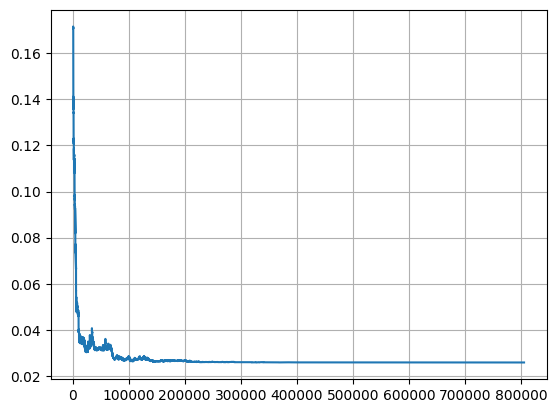

b desired [0.4  0.1  0.2  0.05 0.05 0.   0.2 ]
b found [0.3741 0.0741 0.1741 0.0241 0.0241 0.     0.1741]

difference [0.0259 0.0259 0.0259 0.0259 0.0259 0.     0.0259]
Sup Norm is 0.025921044321227327
L2 norm is 0.0634911750908009

best_phi [0.221 0.061 0.187 0.    0.026 0.    0.185 0.019 0.002 0.026 0.    0.
 0.    0.    0.    0.    0.272 0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.   ]


In [23]:
array = [
    [0.9206, 0, 0, 0, 0, 0, 0.9206, 0, 0, 0, 0.6406, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0.9206, 0, 0, 0, 0, 0, 0.9206, 0, 0, 0, 0.6406, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.07943, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0.9206, 0, 0, 0, 0, 0, 0.9206, 0, 0, 0, 0.6406, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.07943, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0.9206, 0, 0, 0, 0, 0, 0.9206, 0, 0, 0, 0.6406, 0, 0, 0, 0.6406, 0, 0, 0, 0, 0, 0.07943, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0.9206, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.6406, 0, 0, 0, 0.6406, 0, 0, 0, 0, 0, 0.07943, 0, 0, 0, 0, 0.07943],
    [0, 0, 0, 0, 0, 0.9206, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.6406, 0, 0, 0, 0.6406, 0.07943, 0, 0, 0, 0, 0.07943, 0, 0, 0.07943, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.6406, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.07943, 0.07943, 0, 0]
]

# Example usage (assuming 'A' and 'b' are defined)

A = np.array(array)

# Initializing the B Vector
b = [0.4, 0.1, 0.2, 0.05, 0.05, 0, 0.2]
b = np.array(b)
counter, error_values, best_phi, b_found, score = montecarlo(A, b)


## Vertex Walk with CDD

### Practicing with cdd

Check out this link to install cdd
https://pycddlib.readthedocs.io/en/latest/quickstart.html

In [24]:
import cdd as pcdd
array = [
    [4 / 3, -2, -1],  # 0 <= 4/3-2x-y
    [2 / 3, 0, -1],  # 0 <= 2/3-y
    [0, 1, 0],  # 0 <= x
    [0, 0, 1],  # 0 <= y
    [0, 3, 4],  # obj func: 3x+4y
]
#lp = cdd.linprog_from_array(array, obj_type=cdd.LPObjType.MAX)
#cdd.linprog_solve(lp)
#lp.status == cdd.LPStatusType.OPTIMAL

#lp.obj_value
#
#lp.primal_solution
# Define the array representing inequalities and boundaries


# Create a matrix from the array using inequality representation
mat = pcdd.matrix_from_array(array, rep_type=pcdd.RepType.INEQUALITY)

# Construct a polyhedron from the matrix
poly = pcdd.polyhedron_from_matrix(mat)

# Copy the generators of the polyhedron
gen = pcdd.copy_generators(poly)

# Check the representation type of the generators
gen.rep_type

# Print the array of generators
print(gen.array)

#gen.lin_set

solutions = np.array(gen.array)
solutions = solutions[:,1:]
solutions

print('Array')
print(array)

[[1.0, 0.0, 0.6666666666666666], [1.0, 0.0, 0.0], [1.0, 0.6666666666666666, 0.0], [1.0, 0.3333333333333333, 0.6666666666666666]]
Array
[[1.3333333333333333, -2, -1], [0.6666666666666666, 0, -1], [0, 1, 0], [0, 0, 1], [0, 3, 4]]


In [25]:
import cdd
import numpy as np

def vertexcddlist(A, b):
    # Number of variables
    num_vars = A.shape[1]
    
    # Step 1: Add non-negativity constraints
    negative_identity = -np.eye(num_vars)
    
    # Step 2: Add sum constraint
    sum_constraint = np.ones((1, num_vars))
    
    # Stack constraints
    A = np.vstack((A, sum_constraint, negative_identity))
    
    #print('Debugging b', b, b.shape)
    # Step 4: Update b vector
    b = np.hstack((b, 1, np.zeros(num_vars)))  # Append 1 for the sum constraint and zeros for non-negativity
    
    # Step 5: Create inequality representation
    array = np.hstack((b.reshape(-1, 1), -A))
    
    # Create a matrix from the array using inequality representation
    mat = cdd.matrix_from_array(array, rep_type=cdd.RepType.INEQUALITY)
    cdd.matrix_canonicalize(mat)

    # Construct a polyhedron from the matrix
    poly = cdd.polyhedron_from_matrix(mat)

    # Remove redundant constraints
    # poly.remove_redundant()  # Uncomment if needed

    # Copy the generators of the polyhedron
    gen = cdd.copy_generators(poly)

    # Extract the solutions (generators) and ignore the first column
    solutions = np.array(gen.array)
    solutions = solutions[:, 1:]  # Ignore the first column (b values)
    print('Vertices found:', solutions.shape[0], '    Dimension of phi', solutions.shape[1])

    return solutions


def find_supnorm_vertices(A,b,solutions):
    best_vertices=[]
    best_sup_norm = np.inf
    for boogers in solutions:
        
        sup_norm = np.max((b-A@boogers ))

        if sup_norm == best_sup_norm:
            best_vertices.append(boogers)
        
        if sup_norm < best_sup_norm:
            best_vertices=[]
            best_sup_norm = sup_norm
            best_vertices.append(boogers)

    best_vertices = np.array(best_vertices)

    print()
    print('Sup norm', best_sup_norm)
    print('number of best points',(best_vertices.shape[0]))
    print('Example of Best Vertex', best_vertices[0])
    print("Number of active constraints", A.shape[0] +(A.shape[1]-np.count_nonzero( best_vertices[0])))
    print('Sum of example phi',np.sum(best_vertices[0]))
    
    

    return best_vertices, best_sup_norm


solutions = vertexcddlist(A, b)
best_vertices, best_sup_norm = find_supnorm_vertices(A,b,solutions)



Vertices found: 16516     Dimension of phi 30

Sup norm 0.05
number of best points 8
Example of Best Vertex [0.43449924 0.10862481 0.21724962 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.23962633 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.        ]
Number of active constraints 33
Sum of example phi 1.0


## Now the linearization approach with ccd

In [26]:
# A and b are defined above

def vertexcddlist2(A, b):
    # Number of variables
    num_vars = A.shape[1]
    
    # Step 1: Add non-negativity constraints
    negative_identity = -np.eye(num_vars)
    
    # Step 2: Add sum constraint
    sum_constraint = np.ones((1, num_vars))
    sum_constraint[0, -1] = 0
    #print(sum_constraint)

    
    # Stack constraints
    A = np.vstack((A, sum_constraint, negative_identity))
    
    # Step 4: Update b vector
    b = np.hstack((b, 1, np.zeros(num_vars)))  # Append 1 for the sum constraint and zeros for non-negativity
    
    # Step 5: Create inequality representation
    array = np.hstack((b.reshape(-1, 1), -A))
    
    # Create a matrix from the array using inequality representation
    mat = cdd.matrix_from_array(array, rep_type=cdd.RepType.INEQUALITY)
    cdd.matrix_canonicalize(mat)

    # Construct a polyhedron from the matrix
    poly = cdd.polyhedron_from_matrix(mat)

    # Remove redundant constraints
    # poly.remove_redundant()  # Uncomment if needed

    # Copy the generators of the polyhedron
    gen = cdd.copy_generators(poly)

    # Extract the solutions (generators) and ignore the first column
    solutions = np.array(gen.array)
    solutions = solutions[:, 1:]  # Ignore the first column (b values)
    print('Vertices found:', solutions.shape[0], '    Dimension of phi', solutions.shape[1])

    return solutions



def linear_reformulation(A,b):


    # Creating Augmented A and Augmented b matrix
    A_ub = np.hstack([A, -np.zeros((A.shape[0], 1))])
    A_ub = np.vstack( [A_ub, np.hstack ([-A, -np.ones((A.shape[0], 1))] )])
    b_ub = np.hstack([b, -b])

    return A_ub, b_ub

def find_supnorm_vertices2(A,b,solutions):
    best_vertices=[]
    best_sup_norm = np.inf
    for boogers in solutions:
        
        sup_norm = np.max((b-A@boogers ))

        if sup_norm == best_sup_norm:
            best_vertices.append(boogers)
        
        if sup_norm < best_sup_norm:
            best_vertices=[]
            best_sup_norm = sup_norm
            best_vertices.append(boogers)

    best_vertices = np.array(best_vertices)

    print()
    print('Sup norm', best_sup_norm)
    print('number of best points',(best_vertices.shape[0]))
    print('Example of Best Vertex', best_vertices[0,:-1])
    print("Number of active constraints", A.shape[0] +(A.shape[1]-np.count_nonzero( best_vertices[0])))
    print('Sum of example phi',np.sum(best_vertices[0])-best_sup_norm)
    
    

    return best_vertices, best_sup_norm


# Linear Reformulation
A_ub, b_ub = linear_reformulation(A,b)

solutions2 = vertexcddlist2(A_ub, b_ub)
best_vertices2, best_sup_norm2 = find_supnorm_vertices2(A_ub,b_ub,solutions2)



Vertices found: 58825     Dimension of phi 31

Sup norm 0.025915132408575126
number of best points 16
Example of Best Vertex [0.         0.         0.         0.         0.02616214 0.
 0.40634898 0.08047455 0.18909936 0.02616214 0.         0.
 0.         0.         0.         0.         0.27175284 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.        ]
Number of active constraints 38
Sum of example phi 0.9999999999999998


### Now trying it with the 10x100

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Model 11 predicts: 9
Softmax outputs: [[0.01 0.08 0.06 0.01 0.09 0.02 0.08 0.14 0.02 0.48]]


F has a sparcity  0.309

[[0.    0.    0.    0.138 0.    0.475 0.    0.    0.145 0.   ]
 [0.822 0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.021 0.    0.    0.    0.075 0.03  0.    0.255 0.026 0.352]
 [0.    0.    0.    0.    0.    0.    0.    0.805 0.    0.018]
 [0.    0.    0.    0.025 0.    0.    0.    0.734 0.019 0.043]
 [0.    0.    0.047 0.596 0.    0.092 0.    0.    0.022 0.   ]
 [0.8   0.    0.    0.    0.    0.    0.    0.023 0.    0.   ]
 [0.    0.    0.    0.    0.106 0.    0.    0.106 0.    0.542]
 [0.    0.    0.607 0.057 0.    0.    0.025 0.    0.    0.   ]
 [0.    0.    0.    0.    0.016 0.    0.74  0.    0.    0.   ]
 [0.    0.824 0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.823 0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.396 0.    0.033 0.    0.164 0.    0.165 0.    0.    0.   ]
 [0.    0.06  0.    0.  

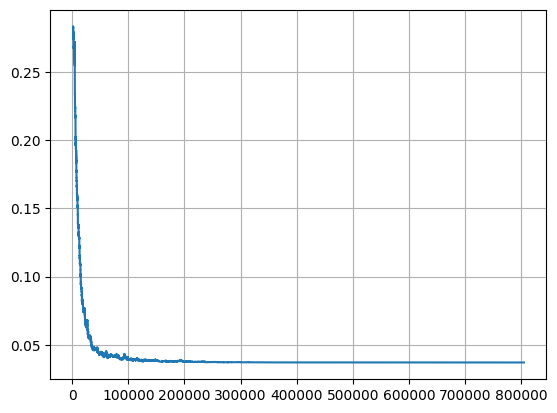

b desired [[0.007  0.0846 0.0576 0.0088 0.0927 0.0249 0.0848 0.1445 0.0176 0.4775]]
b found [0.0019 0.0476 0.0207 0.0034 0.0849 0.002  0.0479 0.1076 0.0018 0.4406]

difference [[0.0051 0.037  0.037  0.0053 0.0078 0.0229 0.037  0.037  0.0159 0.037 ]]
Sup Norm is 0.03695575290664734
L2 norm is 0.08786870085607171

best_phi [0.    0.    0.065 0.    0.    0.    0.    0.129 0.009 0.    0.005 0.
 0.    0.002 0.    0.    0.    0.    0.    0.    0.003 0.066 0.014 0.
 0.    0.    0.004 0.019 0.003 0.    0.    0.015 0.021 0.    0.    0.
 0.015 0.133 0.    0.    0.054 0.123 0.    0.001 0.    0.    0.011 0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.001 0.    0.    0.    0.001 0.    0.    0.171 0.    0.    0.    0.084
 0.024 0.    0.    0.    0.    0.    0.    0.    0.004 0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.008 0.    0.
 0.    0.    0.    0.017]


In [27]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
import tensorflow as tf

# Load the MNIST expert model 11
model_path = 'mnist_expert11.keras'  # Adjust this path to where your model is stored
mnist_expert11 =load_model(model_path)

# Image Resized defined above

# Predict using the loaded model
guess = mnist_expert11.predict(image_resized.reshape(1, 28, 28, 1))
guess += np.random.uniform(0, 0.2, 10)
guess /= guess.sum() 
print('Model 11 predicts:', np.argmax(guess))
print('Softmax outputs:', np.round(guess, 2))
print()
print()


num_classes = 10
num_images = 100
F = np.zeros((num_classes, num_images))  # (10, 10000)
for class_idx in range(num_classes):
    for image_idx in range(num_images):
        mean_confidence = results[0, class_idx, image_idx]
        std_deviation = results[1, class_idx, image_idx]

        if mean_confidence == 0:
            F[class_idx, image_idx] = 0  # Directly assign 0
        else:
            F[class_idx, image_idx] = np.random.normal(mean_confidence, std_deviation)

        # Clipping values to ensure they are within the [0, 1] range
        F[F < 0] = 0
        F[F > 1] = 1
print('F has a sparcity ', np.count_nonzero(F)/1000)
print()
print(np.round(F.T,3))


counter, error_values, best_phi, b_found, score = montecarlo(F, guess)

In [28]:
## Trying for Linearize with Scipy

A = np.array(F.copy())
b = np.array(guess)

t, x, b_found, bdifference = linearizewithscipy(A, b)

Optimal value of objective function: 0.028045516646246334
Optimal solution x: [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.07672315 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.06852728 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.20874001 0.         0.         0.6033654  0.00268482
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.03995934 0.    

### Vertexccd crashes due to dimentionality problems - runs infinitely

In [29]:
# solutions = vertexcddlist(F, guess.flatten())
# print(solutions.shape)
# print(solutions)

### VertexCCd with sup reformulation

In [30]:
# # Linear Reformulation
# A_ub, b_ub = linear_reformulation(F,guess.flatten())

# solutions2 = vertexcddlist2(A_ub, b_ub)
# best_vertices2, best_sup_norm2 = find_supnorm_vertices2(A_ub,b_ub,solutions2)

### Dimensionality Reduction

In [41]:
rows_to_remove = []
tol = 0.1#np.max(bdifference)
for ii in range(A.shape[1]):
    row1 = A[:, ii] # Get first row
    for jj in range(ii+1, A.shape[1]): # For every other row.
        row2 = A[:,jj]
        if np.linalg.norm(row1 - row2, ord=np.inf) < tol:
            rows_to_remove.append(jj)
            #print("Look at what's being removed")
            #print()
            #print(A[:,ii])
            #print(A[:,jj])
#print(rows_to_remove)
rows_to_remove = np.array(rows_to_remove)

unique_rows = np.delete(A, rows_to_remove, axis=1)

print('Size of reduced Matrix', unique_rows.shape)

t, x, b_found, bdifference = linearizewithscipy(unique_rows, b)


Size of reduced Matrix (10, 34)
Optimal value of objective function: 0.035660497412583085
Optimal solution x: [0.         0.         0.         0.         0.         0.8021787
 0.03615261 0.06521677 0.05935718 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.03709474 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]

b desired [[0.00700368 0.08456784 0.05762031 0.00877048 0.09266131 0.02489437
  0.08481181 0.14452276 0.01762201 0.47752544]]
b found   [0.    0.049 0.022 0.002 0.086 0.    0.049 0.109 0.    0.442]

difference [[0.007 0.036 0.036 0.007 0.007 0.025 0.036 0.036 0.018 0.036]]
L1 norm is: 0.035660497412583085
L2 norm is:  0.08616794917358653


In [42]:
np.max(unique_rows)
print(np.max(unique_rows))
unique_rows = np.array(unique_rows)
solutions3 = vertexcddlist(unique_rows, guess.flatten())
print(solutions3.shape)
print(solutions3)
best_vertices, best_sup_norm = find_supnorm_vertices(unique_rows, guess.flatten(),solutions3)


0.8239500041510643
Vertices found: 981526     Dimension of phi 34
(981526, 34)
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.0085213  0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.01232631 0.         0.        ]]

Sup norm 0.05421195974321902
number of best points 2
Example of Best Vertex [0.         0.         0.         0.         0.         0.77433688
 0.         0.         0.04553284 0.         0.         0.
 0.         0.         0.         0.04945082 0.         0.
 0.         0.         0.         0.         0.         0.04039326
 0.01558223 0.         0.         0.         0.07470397 0.
 0.         0.         0.         0.        ]
Number of active constraints 38
Sum of exam

In [ ]:
A_ub2, b_ub2 = linear_reformulation(unique_rows, guess.flatten())

solutions4 = vertexcddlist2(A_ub2,b_ub2)
print(solutions4.shape)
print(solutions4)
best_vertices4, best_sup_norm4 = find_supnorm_vertices2(unique_rows, guess.flatten(),np.array(solutions4))


## 3.1 A Posteriori Problem

### 3.1.1 Algorithm 2

I could not implement this for 2 reasons.
1) M* is not defined in the literature.
2) I did not perform a vertex walk for the v' Instead, I use supNorm Minimization above.


#### Algorithm 2 as presented

**Initialize**:
- M* <-- 2
- v' <-- 0
- {v'} is empty

**Begin vertex walk**:
- **Repeat**:
  1. Generate next vertex v'
  2. Compute vector sample L <-- F^T v'
  3. Find M*

  - If M* strictly decreased:
    - Empty {v'}
    - Remember new minimum M* value
    - Restart collection with v'

  - If M* did not change:
    - Add v' to {v'} collection

  - If M* strictly increased:
    - Do nothing

  - Vertex walk to next v' vertex

- **Until** v' = 0

**Monte Carlo Sampling**:
- Choose a large integer N.
- Transform link certitudes f_{i,j} into distribution functions, F_{i,j}, for each link Φ_i → L_j.

- **Repeat** N times:
  1. Select the values of the weights λ_k uniformly, randomly: P_{λ_k} = 1, λ_k ≥ 0.
  2. Form a solution vector phi~ = ∑_{v'} λ_k v'.
  3. Make random selections for each f_{i,j} based on certitude functions.
  4. Compute observed L~ = F^T *Phi~* and add to histogram.

- **End Repeat**

- Normalize the resulting raw histogram to unit area.


### 3.1.2 An Alternate Algorithm

- **Initialize**:
  - **L** = []
  - **Φ** = []
  - A = very large number
  - B = very large number

- **Input** $ \hat{L} $

- **Loop A times**:
  1. Sample $ F $ to create $ \hat{F} $.
  2. Solve $ \hat{F} \hat{\Phi} = \hat{L} $ for $ \hat{\Phi} $.
  3. Append $ \hat{\Phi} $ to **Φ**.

- **Loop B times**:
  1. Sample $ F $ to create $ \tilde{F} $.
  2. Sample **Φ** to create $ \tilde{\Phi} $.
  3. Solve $ \tilde{L} = \tilde{F} \tilde{\Phi} $ for $ \tilde{L} $.
  4. Append $ \tilde{L} $ to **L**.

- **Create a normalized histogram** of **L**.
- **Create a normalized histogram** of **Φ**.


In [34]:
# import cv2
# import numpy as np
# import matplotlib.pyplot as plt
# from skimage.metrics import structural_similarity as ssim
# import tensorflow as tf

# # Load the MNIST expert model 11
# model_path = 'mnist_expert11.keras'  # Adjust this path to where your model is stored
# mnist_expert11 =load_model(model_path)

# # Image Resized defined above

# # Predict using the loaded model
# guess = mnist_expert11.predict(image_resized.reshape(1, 28, 28, 1))
# print('Model 11 predicts:', np.argmax(guess))
# print('Softmax outputs:', np.round(guess, 2))
# print()

In [35]:
# import numpy as np
# from scipy.optimize import linprog
# import matplotlib.pyplot as plt

# A = 200 # 300 takes 30 seconds
# B = 200

# L = guess.copy()

# L_all = []
# Phi_all = []

# # Random Block needed to get this to work:
# num_classes = 10
# num_images = 100

# def solve_linear_program(F, L):
#     # Ensure F and L are numpy arrays
#     A = np.array(F)
#     b = np.array(L)

#     # Define the length of x
#     x_len = A.shape[1]

#     # Objective function: Minimize t
#     c = np.zeros(x_len + 1)  # n_vars for x and 1 for t
#     c[-1] = 1  # Coefficient of t in the objective function

#     # Augmented A and b matrix for constraints
#     A_ub = np.hstack([A, -np.ones((A.shape[0], 1))])
#     A_ub = np.vstack([A_ub, np.hstack([-A, -np.ones((A.shape[0], 1))])])
#     b_ub = np.hstack([b, -b])

#     # Additional constraints: sum(x) <= 1
#     A_eq = np.zeros((1, x_len + 1))
#     A_eq[0, :x_len] = 1
#     b_eq = [1]

#     # Bounds for x and t
#     bounds = [(0, 1)] * x_len + [(0, None)]  # x in [0, 1] and t in [0, inf]

#     # Solve the linear programming problem
#     res = linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, bounds=bounds, method='highs')

#     # Extracting the solution
#     x = res.x[:-1]

    
#     return x


# # Generate Phi_all
# for acount in range(A):
    
#     # Sample F
#     F = np.zeros((num_classes, num_images))  # (10, 10000)
#     for class_idx in range(num_classes):
#         for image_idx in range(num_images):
#             mean_confidence = results[0, class_idx, image_idx]
#             std_deviation = results[1, class_idx, image_idx]
#             F[class_idx, image_idx] = np.random.normal(mean_confidence, std_deviation)
#     if acount%1000 ==0:
#         print(acount)

#     # Solve for Phi
#     phi = solve_linear_program(F, L)

#     #print("sum of phi",np.sum(np.array(phi)))
#     if phi is not None:
#         # Append Phi
#         Phi_all.append(phi)
#     else:
#         print("Received None for phi. Skipping.")

# # Convert Phi_all to a numpy array for statistical calculations
# Phi_all = np.array(Phi_all)

# if Phi_all.size == 0:
#     raise ValueError("Phi_all is empty. Ensure solve_linear_program is working correctly.")

# # Calculate mean and standard deviation of each element in Phi_all
# phi_mean = np.mean(Phi_all, axis=0)
# phi_std = np.std(Phi_all, axis=0)
# print("Done with Loop A")


# # Generate L_all
# for bcount in range(B):
#     # Sample F
#     F = np.zeros((num_classes, num_images))  # (10, 10000)
#     for class_idx in range(num_classes):
#         for image_idx in range(num_images):
#             mean_confidence = results[0, class_idx, image_idx]
#             std_deviation = results[1, class_idx, image_idx]
#             F[class_idx, image_idx] = np.random.normal(mean_confidence, std_deviation)
#             #print(np.max(F))
#     if bcount%500 ==0:
#         print(bcount, "B Side")
#     # Sample Phi 
#     phi_tilde = np.random.normal(phi_mean, phi_std) # I am not sure if this is the best way, or to generate a random index, and then choose that phi[random_index]
#     phi_tilde = np.exp(phi_tilde) /np.exp(phi_tilde).sum() # or to normalize after? Or pass through a softmax?
#     #print(phi_tilde)
#     # Solve for L
#     Lhat = F.dot(phi_tilde)
#     print(Lhat)
#     # Append L
#     L_all.append(Lhat)


# # Convert L_all to a numpy array
# L_all = np.array(L_all)




In [36]:
# import numpy as np
# import matplotlib.pyplot as plt


# L_all2 = L_all.copy()

# means = np.mean(L_all2, axis=0)
# vars = np.var(L_all2, axis=0)
# print("Mean of each label:")
# for i, mean in enumerate(means):
#     print(f"Label {i}: {mean:.2f}", "var", np.round(vars[i],3))



# # Plot histograms on a single plot
# plt.figure(figsize=(12, 8))

# for i in range(L_all2.shape[1]):
#     plt.hist(L_all2[:, i], bins=100, alpha=0.5, label=f'Label {i}')

# plt.title('Histograms of All Labels')
# plt.xlabel('Value')
# plt.ylabel('Frequency')
# plt.legend(loc='upper right')
# plt.show()


# # Showing a clipped version

# L_all2 = np.clip(L_all2,0,1)
# means = np.mean(L_all2, axis=0)
# vars = np.var(L_all2, axis=0)
# print("Mean of each label:")
# for i, mean in enumerate(means):
#     print(f"Label {i}: {mean:.2f}", "var", np.round(vars[i],3))



# # Plot histograms on a single plot
# plt.figure(figsize=(12, 8))

# for i in range(L_all2.shape[1]):
#     plt.hist(L_all2[:, i], bins=100, alpha=0.5, label=f'Label {i}')

# plt.title('Histograms of All Labels')
# plt.xlabel('Value')
# plt.ylabel('Frequency')
# plt.legend(loc='upper right')

# plt.show()


#### A faster implementation

# Appendix

#### 1.8 Special Request: Spreadsheet for Dr. Klienhenz

Unfortunately, I don't remember the details for this request.  
More research is needed for implementation.  

Run this with the smaller Ground Truth Data Set
cough cough - maybe something for Varun to do.

In [37]:
# import numpy as np
# import matplotlib.pyplot as plt
# from tensorflow.keras.models import load_model

# # True classes from the full test_labels
# true_classes_full = np.argmax(test_labels, axis=1)

# # Create a balanced subset of 100 images, ensuring each digit 0-9 is represented equally
# indices_per_class = 10  # Number of indices per class to achieve 100 images total
# selected_indices = []

# for digit in range(10):
#     digit_indices = np.where(true_classes_full == digit)[0]
#     selected_digit_indices = np.random.choice(digit_indices, indices_per_class, replace=False)
#     selected_indices.extend(selected_digit_indices)

# # Ensure the selected indices are shuffled to mix the digits
# np.random.shuffle(selected_indices)

# # Slicing the test_images and test_labels to get only the selected subset
# subset_test_images = test_images[selected_indices]
# subset_test_labels = test_labels[selected_indices]

# # Load models and get predictions
# num_models = 10  # Specify the number of models
# predictions = []

# for i in range(1, num_models + 1):
#     model = load_model(f"mnist_expert{i}.keras")  # Load each model
#     pred = model.predict(subset_test_images)  # Predict with the model on the subset
#     predictions.append(pred)

# # Open a text file for writing results
# with open('prediction_results.txt', 'w') as file:
#     # Write header
#     file.write("Image Index, Model Number, Predicted Class, Softmax Output\n")
    
#     # For each model, write prediction results for each image
#     for i in range(num_models):
#         for j in range(len(subset_test_images)):
#             predicted_class = np.argmax(predictions[i][j])
#             softmax_output = np.max(predictions[i][j])
#             expert_accuracy = scores[i]
#             # Write to file
#             file.write(f"{j}, Expert {i+1}, {expert_accuracy:.4f}, {predicted_class}, {softmax_output:.4f}\n")

# print("Prediction results have been written to 'prediction_results.txt'.")
